# Client Retention Demo
In this demo, we will show Anaconda functionality accessing enterprise data from VSAM and DB2. The data stored in VSAM consists of 6001 rows of customer information.  The data stored in DB2 consists of 20,000 rows of transaction data. The data is transformed and joined to create a third table used to perform exploratory analyses. A random forest algorithm is then used to predict customer churn.

In [1]:
USERNAME="SPK????"
PASSWORD="????????"
MDSS_SSID="AZK1"
DB2_SSID="DBBG"

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

## Set up Mainframe Data Connections
This step will set up the VSAM and DB2 connections to access the data and load them into Pandas DataFrames.  The dsdbc module is delivered with the z/OS IzODA Anaconda distribution. It enables Python applications to access the z/OS IzODA Mainframe Data Service. The Data Service component (MDS) provides optimized, virtualized, and parallelized access to both IBM Z data sources and other off-platform data sources.

In [2]:
def cp1047_to_utf8(list):
    list_out = []
    for e in list:
        x = ()
        for i in e:
            if isinstance(i, (str,)):
                s = i.encode('utf16').decode('cp1047').encode('utf8').decode('utf16')[2:]
                x = x + (s,)
            else:
                x = x + (i,)
        list_out.append(x)
    return list_out

def load_data_from_mds(vtable_name, user, password, mds_id=MDSS_SSID):
    import dsdbc
    conn =dsdbc.connect(SSID=mds_id, user=user, password=password)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM " + vtable_name)
    rows = cursor.fetchall()
    label = []
    for col in cursor.description: label.append(col[0].lower())
    conn.close()
    return pd.DataFrame(rows, columns=label)

def load_data_from_db2(table_name, user, password, mds_id=MDSS_SSID,  db2_id=DB2_SSID):
    import dsdbc
    conn =dsdbc.connect(SSID=mds_id, user=user, password=password, dsid=db2_id)
    cursor = conn.cursor()
    sql = "SELECT * FROM " + table_name
    #print(sql)
    cursor.execute(sql)
    rows = cp1047_to_utf8(cursor.fetchall())
    label = []
    for col in cursor.description: label.append(col[0].lower())
    conn.close()
    return pd.DataFrame(rows, columns=label)


***Credit card transactions***

Load credit card transactions into a Pandas DataFrame.

In [3]:
txn_df = load_data_from_db2(table_name='SPARKDB.SPPAYTB1', user=USERNAME, password=PASSWORD)

In [4]:
txn_df['acaureq_aureq_tx_dt_ttlamt'] = pd.to_numeric(txn_df['acaureq_aureq_tx_dt_ttlamt'])
txn_df['cont_id'] = txn_df['cont_id'].astype('int64')
txn_df['acaureq_hdr_credtt'] = pd.to_datetime(txn_df['acaureq_hdr_credtt'])

In [5]:
txn_df['date'] = txn_df['acaureq_hdr_credtt'].apply(lambda x: x.date())
txn_df

,acaureq_hdr_credtt,acaureq_aureq_env_a_id_id,acaureq_aureq_env_m_id_id,acaureq_aureq_env_m_cmonnm,acaureq_aureq_env_cpl_pan,acaureq_aureq_env_c_cardbrnd,acaureq_aureq_tx_mrchntctgycd,acaureq_aureq_tx_dt_ttlamt,cont_id,mdm_postal_code_id,age,authorresult_rspnt,fraud_ver_result,date
0,2013-04-02 22:47:00.001,BancaItaliana,C0120580917273555,Don't be alone,1009549375,Visa Gold,7273,84.87,1009549370,C012058091,51,APPR,N,2013-04-02
1,2013-01-19 16:55:12.001,BancaItaliana,C0120580915621418,Donna Elegante,1009549375,Visa Gold,5621,179.43,1009549370,C012058091,51,APPR,N,2013-01-19
2,2013-06-03 17:58:05.001,BancaItaliana,C0120580915311606,Rinascimento,1009549375,Visa Gold,5311,140.34,1009549370,C012058091,51,APPR,N,2013-06-03
3,2013-06-02 22:02:00.001,BancaItaliana,C0120580915814746,Eat and Go,1009549375,Visa Gold,5814,144.10,1009549370,C012058091,51,APPR,N,2013-06-02
4,2013-03-02 14:00:00.001,BancaItaliana,C0120580915992763,Florists,1009549375,Visa Gold,5992,111.73,1009549370,C012058091,51,APPR,N,2013-03-02
5,2013-05-02 14:00:00.001,BancaItaliana,C0120580915441513,"Candy,Nut Confectionery",1009549375,Visa Gold,5441,99.76,1009549370,C012058091,51,APPR,N,2013-05-02
6,2013-07-02 14:00:00.001,BancaItaliana,C0120580915977738,Cosmetic Stores,1009549375,Visa Gold,5977,109.12,1009549370,C012058091,51,APPR,N,2013-07-02
7,2013-02-06 16:00:00.001,BancaItaliana,C01205809157221048,All for your House,1009549375,Visa Gold,5722,76.09,1009549370,C012058091,51,APPR,N,2013-02-06
8,2013-09-28 05:09:32.001,BancaItaliana,C0120580915661712,Shoes,1009549375,Visa Gold,5661,269.24,1009549370,C012058091,51,APPR,N,2013-09-28
9,2013-02-06 09:27:21.001,BancaItaliana,C0120580915311917,Allegro,1009549375,Visa Gold,5311,145.03,1009549370,C012058091,51,APPR,N,2013-02-06


***Client Data***

Load client data into a Pandas DataFrame.

In [9]:
client_df = load_data_from_mds(vtable_name='VSAM_CLIENT', user=USERNAME, password=PASSWORD)
client_df = client_df.set_index("cont_id")
client_df

,gender,age_years,highest_edu,annual_invest,annual_income,activity_level,churn,record_id
cont_id,,,,,,,,
1009520370,1,63.23,4,0.0,13035.0,3,0,0
1009520380,1,58.51,1,0.0,18267.0,0,0,600
1009520390,0,31.10,2,111192.0,129276.0,2,0,1200
1009520400,0,49.84,1,0.0,17867.0,2,0,1800
1009520410,1,53.33,1,0.0,17576.0,1,0,2400
1009520420,1,47.72,3,90419.0,111569.0,5,0,3000
1009520430,0,48.46,2,11258.0,20142.0,1,1,3600
1009520440,0,34.38,1,0.0,33727.0,2,0,4200
1009520450,1,47.09,1,0.0,17678.0,2,0,4800


## Aggregate statistics
Calculate a few aggregate statistics based on credit transactions and join the results to the client data DataFrame.

In [10]:
# Total transactions per customer
total_txns_df = txn_df.groupby('cont_id').size().rename("total_txns").to_frame()
client_df = total_txns_df.join(client_df)

In [11]:
# Total transaction amounts per customer
total_txn_amount_df = txn_df.groupby('cont_id')['acaureq_aureq_tx_dt_ttlamt'].sum().rename("total_txn_amount").to_frame()
client_df = client_df.join(total_txn_amount_df)

In [12]:
# Average transaction amounts per customer
avg_txn_amount_df = txn_df.groupby('cont_id')['acaureq_aureq_tx_dt_ttlamt'].mean().rename("avg_txn_amount").to_frame()
client_df = client_df.join(avg_txn_amount_df)

In [13]:
# Average daily transactions per customer
daily_txns = txn_df.groupby(['date', 'cont_id']).size()

In [14]:
# Missing transactions on a particular day means customer had none.
# These days should be included in the average as 0 transaction days.
avg_daily_txns_df = daily_txns.unstack().fillna(0).mean().rename("avg_daily_txns").to_frame()
client_df = client_df.join(avg_daily_txns_df)

## Show Results

In [15]:
client_df

,total_txns,gender,age_years,highest_edu,annual_invest,annual_income,activity_level,churn,record_id,total_txn_amount,avg_txn_amount,avg_daily_txns
cont_id,,,,,,,,,,,,
1009525770,104,1,24.50,1,0.0,22318.0,2,0,327680,4159.56,39.995769,0.284932
1009526100,244,1,71.56,1,0.0,23688.0,0,1,347480,10196.84,41.790328,0.668493
1009526540,69,0,39.86,1,0.0,22628.0,3,0,374248,3591.61,52.052319,0.189041
1009526580,48,1,85.43,1,0.0,16787.0,4,0,376648,1353.68,28.201667,0.131507
1009526770,69,0,66.09,4,13244.0,44395.0,2,0,388048,4986.94,72.274493,0.189041
1009526780,52,0,34.59,4,0.0,21042.0,1,0,388648,1629.92,31.344615,0.142466
1009526800,173,1,58.91,1,0.0,21897.0,1,0,389848,6584.77,38.062254,0.473973
1009526890,184,1,37.72,1,0.0,22430.0,5,0,395616,7651.12,41.582174,0.504110
1009526940,240,0,22.84,1,0.0,13929.0,1,1,398616,6733.31,28.055458,0.657534


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

### Plot X vs. Y
We begin our exploration of the data set by creating some scatterplots of each column vs. the others.

In [17]:
def jointplot(x, y, data, **kwargs):
    size = kwargs.pop('size', 10)
    alpha = kwargs.pop('alpha', 0.3)
    return sns.jointplot(x=x, y=y, data=data, 
                         alpha=alpha,
                         size=size,
                         **kwargs)

# for widget
def w_jointplot(x, y):
    g = jointplot(x, y, filter_outliers(client_df, by_col=y))
    plt.close()
    return g.fig

In [18]:
churn_labels = ['Did not churn', 'Did churn']

def filter_outliers(d, by_col=None):
    if isinstance(d, pd.
                  Series):
        return d[((d-d.mean()).abs()<=3*d.std())]
    elif isinstance(d, pd.DataFrame):
        if not by_col:
            raise ValueError('by_col is required for DataFrame')
        return d[np.abs(d[by_col]-d[by_col].mean())<=(3*d[by_col].std())] 

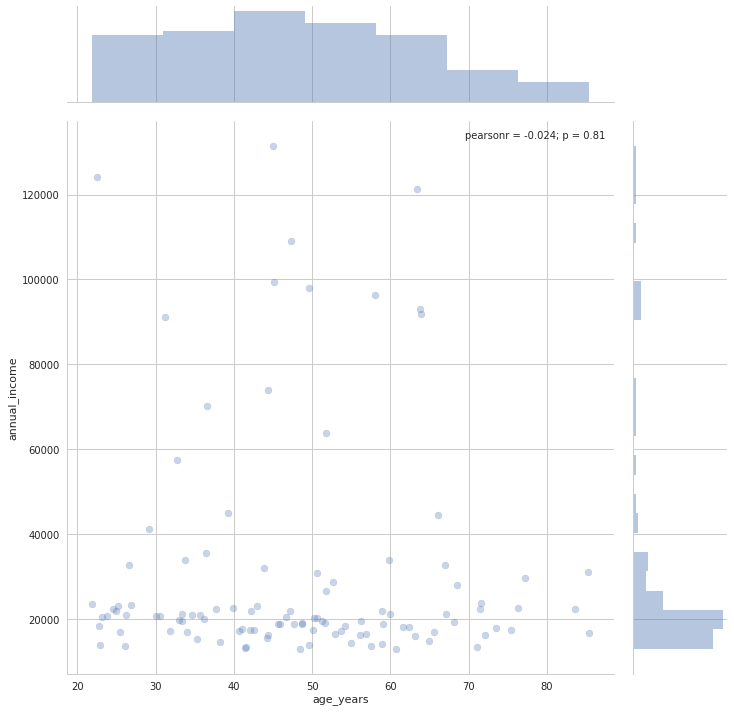

In [19]:
ax = jointplot('age_years', 'annual_income', filter_outliers(client_df, by_col='annual_income'))

### Correlations
Next, we compute the correlation coefficients between each variable.

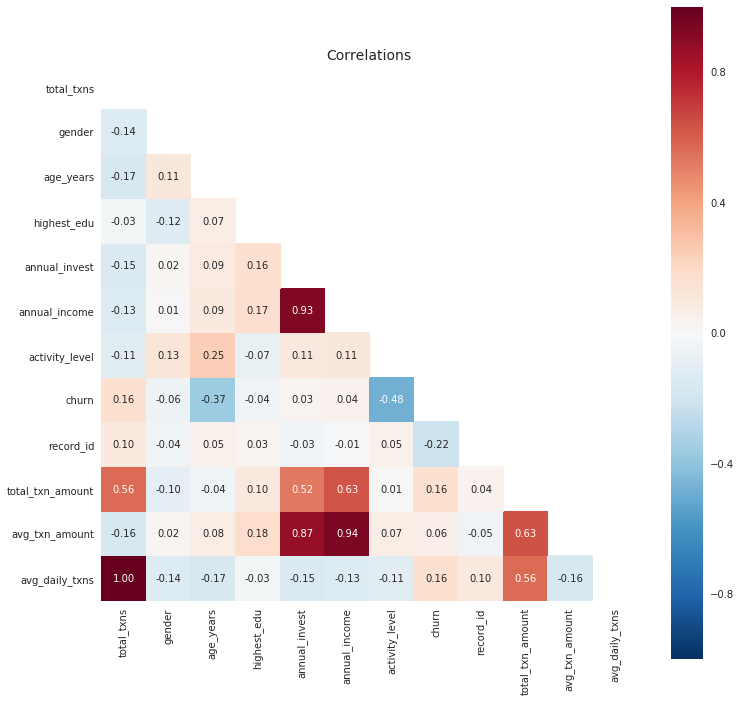

In [20]:
corr = client_df.corr()

# only show lower triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f',
                 cbar=True,
                 ax=ax)
title = ax.set_title('Correlations', size=14)

## Churn
We plot the distributions of clients who churned and those that did not on the same axes.

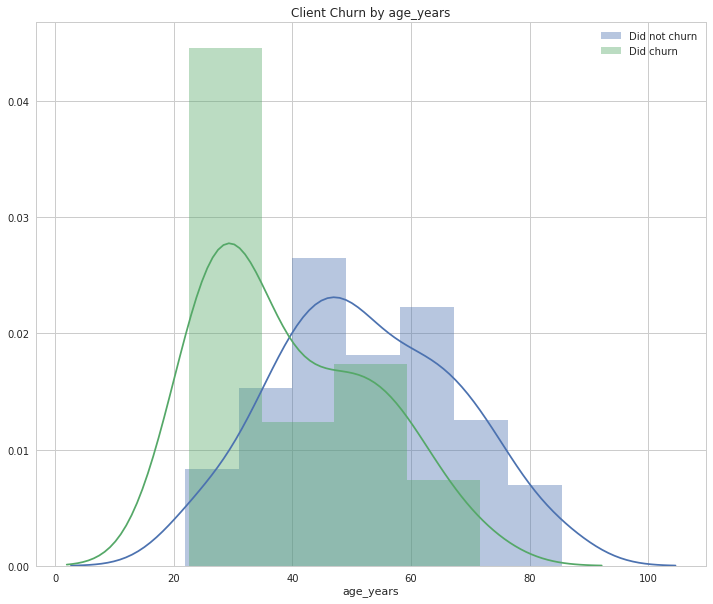

In [21]:
def plot_churn_by(df, col, **kwargs):
    f, ax = plt.subplots(figsize=(12,10), sharex=True)
    kde = kwargs.get('kde', False)
    hist = kwargs.get('hist', False)
    for churn in df.churn.unique():
        sns.distplot(df[df.churn == churn][col], 
                     label=churn_labels[churn], 
                     kde_kws={'shade': (kde and not hist)},
                     ax=ax, 
                     **kwargs)

    ax.set_title('Client Churn by {}'.format(col))
    label = ax.set_xlabel('{}'.format(col))
    return f, ax

def w_plot_churn_by(column, hist=True, kde=False, norm_hist=False):
    df = filter_outliers(client_df, by_col=column)
    f, ax = plot_churn_by(df, column, hist=hist, kde=kde, norm_hist=norm_hist)
    plt.legend()
    plt.close()
    return f

f, ax = plot_churn_by(client_df, 'age_years')
ax = plt.legend()

The two features that showed a negative correlation with churn were age and activity level. Here we generate a boxplot with those two features as the axes, and churn as the category.
The plot shows that clients that churn tend to be younger across all levels of activity.

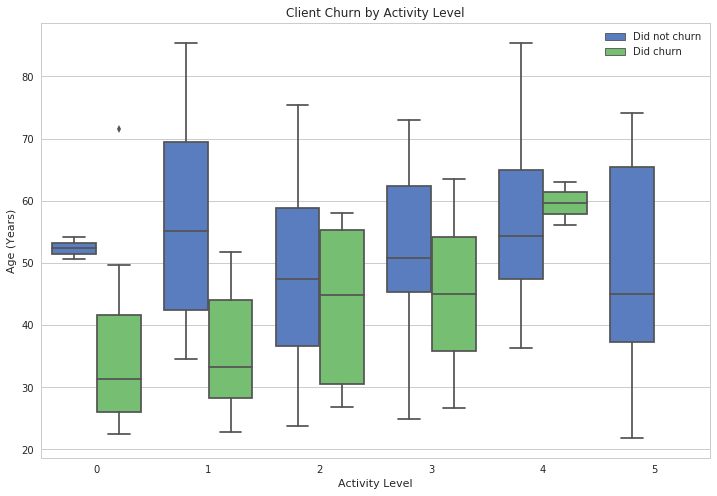

In [22]:
col = 'age_years'
data = filter_outliers(client_df, by_col=col)

f, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x='activity_level', y=col, hue="churn", data=data, 
                 palette='muted', ax=ax)
title = ax.set_title('Client Churn by Activity Level')
label = ax.set_ylabel('Age (Years)')
label = ax.set_xlabel('Activity Level')
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, churn_labels)

This beeswarm plot shows clients binned by the level of activity they maintain with the bank. Clients that churned maintained lower levels of activity (0-2). And of clients within these lower activity levels, younger clients churned more than others.

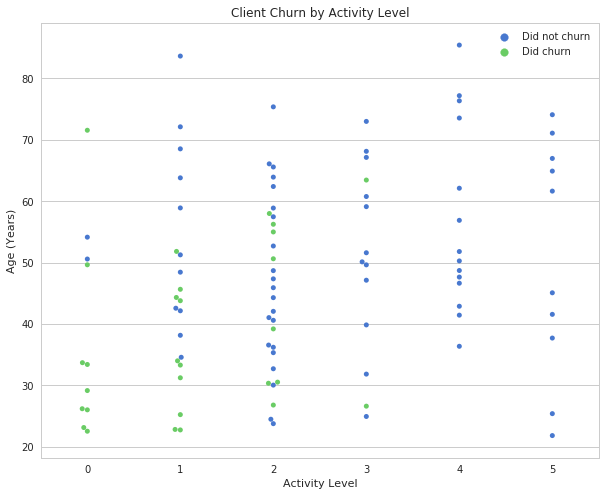

In [23]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.swarmplot(x='activity_level', y='age_years', hue='churn', 
                   data=data.sample(n=100, random_state=51), 
                   palette='muted', ax=ax)
title = ax.set_title('Client Churn by Activity Level')
label = ax.set_ylabel('Age (Years)')
label = ax.set_xlabel('Activity Level')
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, churn_labels)

## Train churn model
Train a churn classifier, which we'll use to predict the probability that a client will churn.
To keep things simple, we use a single data set, which we split into training and test data sets. We use the training data to train the model, and the test data to make projections about lost revenue to the bank.

In [24]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

/home/fztso1/IzODA/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
def make_feature_space(df):
    '''Create the feature space required by our classifier.'''
    # drop columns/features we don't want/need for the classifier
    features_df = df.drop(['churn', 'customer_id'], axis=1, errors='ignore')
    X = features_df.as_matrix().astype(np.float)
    # normalize feature values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

def predict_churn(X):
    '''Predict the probabilit of churn from feature set.'''
    return clf.predict_proba(X)[:,1]

def train_model(X, y):
    '''Train our classifier using features X and target variable y.'''
    clf = RF(n_estimators=100)
    return clf.fit(X, y)

def init_model(df):
    # split data into train, test sets
    train_index, test_index = train_test_split(df.index, random_state=99)
    train_df = client_df.ix[train_index]
    test_df = client_df.ix[test_index]

    # target variable
    y = np.array(train_df['churn'])

    # extract features
    X = make_feature_space(train_df)

    # train classifier
    clf = train_model(X, y)

    return clf, test_df

After training the model, we are left with the churn classifier and the test data set, which we'll use for our churn predictions.

In [26]:
clf, test_df = init_model(client_df)

## Calculate business loss
In this simple example, we calculate the projected loss of business (revenue) to BigBank for all clients in the test data set. We calculate BigBank's revenue from each client, and multiply that by the churn probability to determine the predicted loss.

In [27]:
def calc_business_loss(df):
    df['customer_id'] = df.index
    data = df.copy()

    # extract features
    X = make_feature_space(df)
    
    # predict churn
    data['churn_probability'] = predict_churn(X)
    
    # TODO: avg_daily_balance would be a nice feature to have here
    # for now, we'll just use fraction of income
    avg_daily_balance = df['annual_income'] / 6

    # Interest made on deposits
    deposit_rate = 0.02

    # Fee collected for each credit txn
    credit_rate = 0.015

    # Assume we make some money on trading fees and/or portfolio management
    mgmt_rate = 0.02

    # How much is each customer worth to the business?
    worth = deposit_rate * avg_daily_balance + \
            mgmt_rate * df['annual_invest'] + \
            credit_rate * df['total_txn_amount']
    data['worth'] = worth
    
    # How much would we lose per annum?
    data['predicted_loss'] = data['churn_probability'] * worth
    
    return data.sort_values(by='predicted_loss', ascending=False)

In [28]:
churn_df = calc_business_loss(test_df)
churn_df.head()

,total_txns,gender,age_years,highest_edu,annual_invest,annual_income,activity_level,churn,record_id,total_txn_amount,avg_txn_amount,avg_daily_txns,customer_id,churn_probability,worth,predicted_loss
cont_id,,,,,,,,,,,,,,,,
1009554080,192,0,22.55,2,113071.0,124132.0,0,1,2045416,21044.85,109.608594,0.526027,1009554080,0.71,2990.866083,2123.514919
1009529950,301,0,30.36,2,86143.0,176189.0,2,1,581056,39737.90,132.019601,0.824658,1009529950,0.45,2906.225167,1307.801325
1009549370,103,1,73.00,2,113029.0,198514.0,3,0,1759504,13304.49,129.169806,0.282192,1009549370,0.24,3121.860683,749.246564
1009528620,63,0,62.12,3,119243.0,171078.0,4,0,500520,8557.37,135.831270,0.172603,1009528620,0.21,3083.480550,647.530915
1009547530,5,0,44.30,3,85402.0,73856.0,2,0,1648000,390.48,78.096000,0.013699,1009547530,0.32,1960.083867,627.226837


## Loss by Age Group
In this section, we calculate and plot the projected loss of revenue by age group. In our data set, age is an important feature in predicting if a client will churn.
First we create a DataFrame containing the cumulative predicted loss by age group.

In [29]:
def group_by_age(df, bins=None):
    if bins is None:
        bin_size = 5
        _min, _max = int(df.age_years.min()), int(df.age_years.max())
        bins = range(_min, _max + bin_size, 5)
    return df.groupby(pd.cut(df.age_years, bins=bins))

data_by_age = churn_df.pipe(group_by_age)
#data_by_age['predicted_loss'].sum().reset_index()

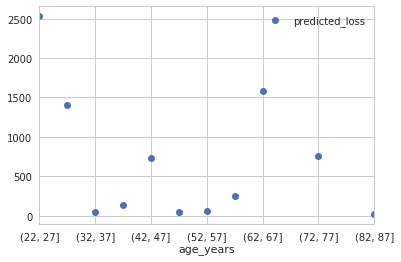

In [30]:
loss_by_age_df = data_by_age['predicted_loss'].sum().reset_index()
loss_by_age_df['age_years'] = loss_by_age_df['age_years'].astype(str)

loss_by_age_df.plot(x='age_years', y='predicted_loss', style='o')